# jobflow

## Define workflow with jobflow

In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

In [3]:
from python_workflow_definition.jobflow import write_workflow_json

In [4]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [5]:
workflow_json_filename = "jobflow_qe.json"

In [6]:
calculate_qe = job(_calculate_qe, data=["energy", "volume", "structure"])
generate_structures = job(_generate_structures, data=[f"s_{i}" for i in range(100)])
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [7]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
structure = get_bulk_structure(
    element="Al",
    a=4.05,
    cubic=True,
)

In [9]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [10]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [11]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [12]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [13]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [14]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [15]:
!cat {workflow_json_filename}

{"nodes": {"0": "quantum_espresso_workflow.get_bulk_structure", "1": "quantum_espresso_workflow.calculate_qe", "2": "quantum_espresso_workflow.generate_structures", "3": "quantum_espresso_workflow.calculate_qe", "4": "quantum_espresso_workflow.calculate_qe", "5": "quantum_espresso_workflow.calculate_qe", "6": "quantum_espresso_workflow.calculate_qe", "7": "quantum_espresso_workflow.calculate_qe", "8": "quantum_espresso_workflow.plot_energy_volume_curve", "9": "Al", "10": 4.05, "11": true, "12": "mini", "13": "python_workflow_definition.shared.get_dict", "14": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, "15": [3, 3, 3], "16": "vc-relax", "17": 0.02, "18": [0.9, 0.9500000000000001, 1.0, 1.05, 1.1], "19": "strain_0", "20": "python_workflow_definition.shared.get_dict", "21": "scf", "22": "strain_1", "23": "python_workflow_definition.shared.get_dict", "24": "strain_2", "25": "python_workflow_definition.shared.get_dict", "26": "strain_3", "27": "python_workflow_definition.shared.get_dict", "28":

## Load Workflow with aiida

In [16]:
from aiida import load_profile

load_profile()

Profile<uuid='bcf9e395e4bf4b64a0a705d8659c0a9c' name='default'>

In [17]:
from python_workflow_definition.aiida import load_workflow_json

In [18]:
wg = load_workflow_json(workflow_json_filename)

In [19]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

04/01/2025 10:52:32 AM <3361007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51189|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure1
04/01/2025 10:52:33 AM <3361007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51189|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1, type: PyFunction, finished.
04/01/2025 10:52:34 AM <3361007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51189|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict10
04/01/2025 10:52:35 AM <3361007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51189|WorkGraphEngine|update_task_state]: Task: get_dict10, type: PyFunction, finished.
04/01/2025 10:52:36 AM <3361007> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51189|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe2
Note: The following floating-point exceptions are signalling: IEEE_INVALID_F

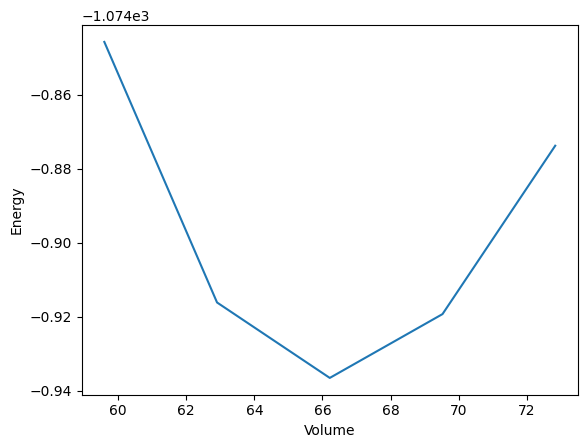

In [20]:
wg.run()

## Load Workflow with pyiron_base

In [21]:
from pyiron_base import Project

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [23]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/17 [00:00<?, ?it/s]

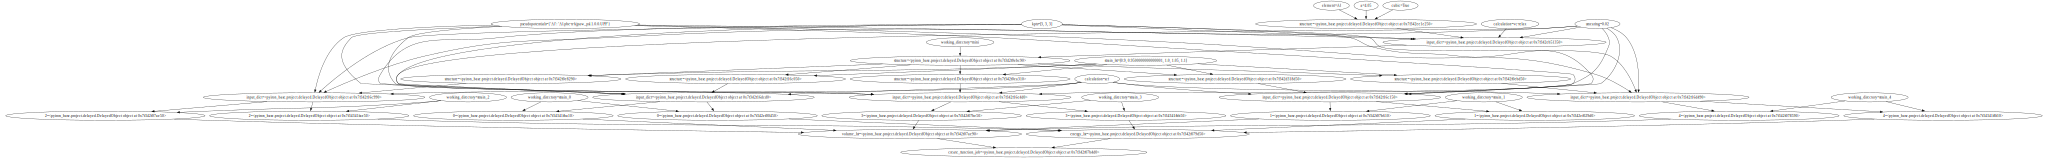

In [24]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 4
The job get_dict_bbed7e528d369f5fa02591748be3166d was saved and received the ID: 5
The job calculate_qe_a8254d13768b11f13ee9368124819d22 was saved and received the ID: 6


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_7c00a7a36fdf7a83905a933d6458c9f6 was saved and received the ID: 7
The job get_dict_9fea1887c87374cda848be8c394400b6 was saved and received the ID: 8
The job calculate_qe_a2a0f9b449a97089f66fd4697c1184d4 was saved and received the ID: 9


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_736160eef13d04e2065cf2c38c62bf47 was saved and received the ID: 10
The job calculate_qe_42a1041b6acc70e91f55e4a2a877ec0b was saved and received the ID: 11


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_618fccf949c159d8a1573c4cda125aae was saved and received the ID: 12
The job calculate_qe_d5f2ff242c26f0b8badef6df9a0504a5 was saved and received the ID: 13


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_61f81e04658f67188ad4502e007fe475 was saved and received the ID: 14
The job calculate_qe_2f09fb4c3a6570dbdc141588f072fec6 was saved and received the ID: 15


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_0bf0210bb59731567645c21e9c07d901 was saved and received the ID: 16
The job calculate_qe_8e0081288044bb59e2eb975aab60c98c was saved and received the ID: 17


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_56b7ebcd322ece2c1200ba8d040fc0bd was saved and received the ID: 18
The job get_list_8d6e79fedf35b08653113905df993b7b was saved and received the ID: 19
The job plot_energy_volume_curve_fa6e68740c464fa9316d532209ff492f was saved and received the ID: 20


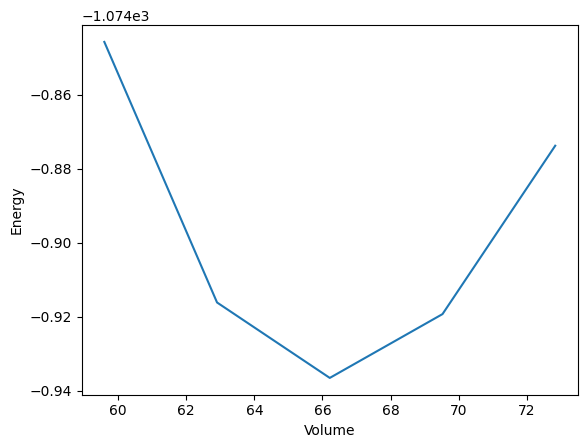

In [25]:
delayed_object.pull()